<a href="https://colab.research.google.com/github/davoodwadi/davoodwadi.github.io/blob/main/High_accuracy_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch, numpy as np, matplotlib.pyplot as plt, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
cifar_train = datasets.CIFAR10(root='./', train=True, download=True)
cifar_test = datasets.CIFAR10(root='./', train=False, download=True)
x_train = torch.tensor(cifar_train.data)
y_train = torch.tensor(cifar_train.targets)
x_test = torch.tensor(cifar_test.data)
y_test = torch.tensor(cifar_test.targets)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

100%|██████████| 170498071/170498071 [00:04<00:00, 42580321.28it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


(torch.Size([50000, 32, 32, 3]),
 torch.Size([10000, 32, 32, 3]),
 torch.Size([50000]),
 torch.Size([10000]))

In [2]:
def channel_first(x):
  return x.permute(0, 3, 1, 2)
x_train = channel_first(x_train).float()
x_test = channel_first(x_test).float()
# Normalize
x_train = (x_train-x_train.mean())/x_train.std()
x_test = (x_test-x_test.mean())/x_test.std()
x_train.mean(), x_train.std(), x_test.mean(), x_test.std()

(tensor(-1.2309e-07), tensor(1.0000), tensor(-1.9903e-07), tensor(1.0000))

In [3]:
class dataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

In [4]:
bs=128

trainset = dataset(x_train, y_train)
testset = dataset(x_test, y_test)
train_loader = DataLoader(trainset, batch_size=bs, shuffle=True)
valid_loader = DataLoader(testset, batch_size=bs)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Training loop

In [6]:
def gpu(bx, by, model):
  bx, by = bx.to(device), by.to(device)
  model = model.to(device)
  return bx, by, model

In [7]:
def train_eval(model, optimizer, train_loader, valid_loader, epoch=3):
  loss_fn = nn.CrossEntropyLoss()
  for e in range(epoch):
    correct = 0
    total = 0
    losses = []

    # training
    model.train()
    for bx, by in train_loader:
      bx, by, model = gpu(bx, by, model)
      output = model(bx)
      loss = loss_fn(output, by)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # validation
    model.eval()
    for bx, by in valid_loader:
      bx, by, model = gpu(bx, by, model)
      with torch.no_grad():
        output = model(bx)
      predictions = output.argmax(-1)

      correct += (predictions==by).float().sum()
      total += len(by)
      losses.append(loss.detach().item())

    accuracy = correct/total
    print(f'epoch {e}; loss {np.mean(losses):.4f}; accuracy {accuracy:.2f}')

## Look at ResNet for inspiration

In [8]:
from torchvision.models import resnet18
resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Let's get rid of Flatten

In [9]:
class ConvNet(nn.Module):
  def __init__(self, layer_filters, stride, kernel_size=3, h=32, w=32, num_classes=10):
    super(ConvNet, self).__init__()
    self.layer_filters = layer_filters
    self.num_layers = len(layer_filters) - 1
    self.layers = nn.ModuleDict()
    for layer in range(1, self.num_layers+1):
      self.layers.add_module(f'layer_{layer}', nn.Conv2d(layer_filters[layer-1], layer_filters[layer], kernel_size, stride, kernel_size//2))
      self.layers.add_module(f'layer_{layer}_bn', nn.BatchNorm2d(layer_filters[layer]))

    self.global_pooling = nn.AdaptiveAvgPool2d(1) # [bs, layer_filters[self.num_layers]]
    self.classification = nn.Linear(layer_filters[self.num_layers], num_classes)

  def forward(self, x):
    for layer_name in self.layers.keys():
      x = self.layers[layer_name](x)
      if 'bn' not in layer_name:
        x = nn.ReLU()(x)

    x = self.global_pooling(x)
    x = x.view(-1, self.layer_filters[-1])
    x = self.classification(x)
    return x


In [10]:
stride = 2
kernel_size = 3
lr = 0.001

depth = 5
ni = 3
nh = 32
layer_filters = [ni] + [nh]*(depth)

model = ConvNet(layer_filters, stride, kernel_size)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train_eval(model, optimizer, train_loader, valid_loader, epoch=10)

epoch 0; loss 2.0003; accuracy 0.25
epoch 1; loss 1.8908; accuracy 0.31
epoch 2; loss 1.8726; accuracy 0.35
epoch 3; loss 1.7112; accuracy 0.38
epoch 4; loss 1.7807; accuracy 0.40
epoch 5; loss 1.6045; accuracy 0.41
epoch 6; loss 1.6745; accuracy 0.42
epoch 7; loss 1.5922; accuracy 0.43
epoch 8; loss 1.6217; accuracy 0.45
epoch 9; loss 1.6355; accuracy 0.45


BatchNorm stabilizes training and enables higher learning rate

In [11]:
stride = 2
kernel_size = 3
lr = 0.01

model = ConvNet(layer_filters, stride, kernel_size)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train_eval(model, optimizer, train_loader, valid_loader, epoch=10)

epoch 0; loss 1.4886; accuracy 0.45
epoch 1; loss 1.2883; accuracy 0.50
epoch 2; loss 1.3096; accuracy 0.53
epoch 3; loss 1.1904; accuracy 0.55
epoch 4; loss 0.9884; accuracy 0.54
epoch 5; loss 1.1231; accuracy 0.58
epoch 6; loss 1.1290; accuracy 0.59
epoch 7; loss 0.8630; accuracy 0.60
epoch 8; loss 1.0820; accuracy 0.59
epoch 9; loss 1.1232; accuracy 0.62


# Data augmentation

Transforms

In [12]:
from torchvision import transforms

In [13]:
bx, by = next(iter(train_loader))
bx.shape

torch.Size([128, 3, 32, 32])

In [14]:
def show_batch(bx):
  fig, axes = plt.subplots(3,3)
  for img, ax in zip(bx, axes.flat):
    img = (img - img.min()) / (img.max()-img.min()) # normalize with min/max
    img = img.permute(1,2,0)
    ax.imshow(img)

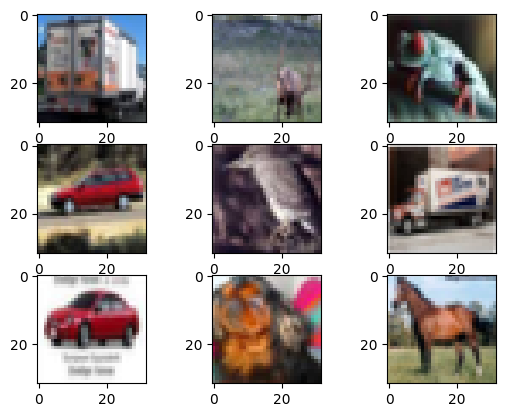

In [15]:
show_batch(bx)

transform the batch using `RandomCrop`

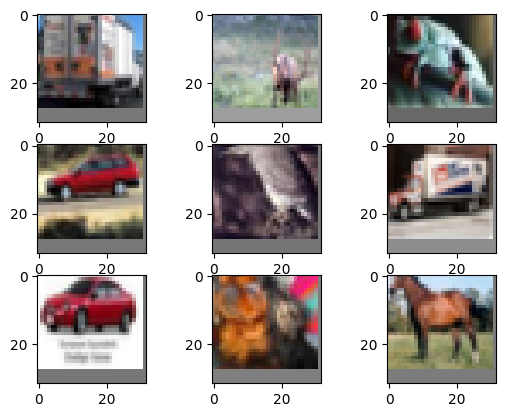

In [16]:
bx_transformed = transforms.RandomCrop(32, padding=4)(bx)
show_batch(bx_transformed)

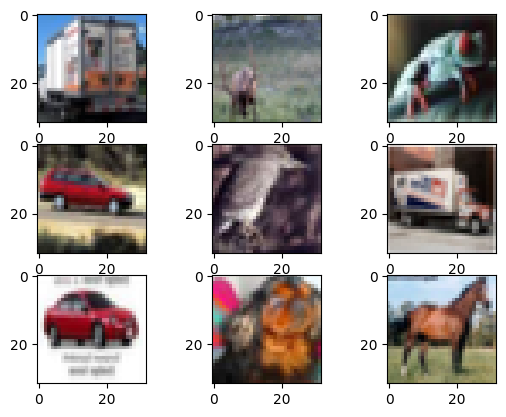

In [17]:
bx_transformed = transforms.RandomHorizontalFlip()(bx)
show_batch(bx_transformed)

Let's combine the transforms

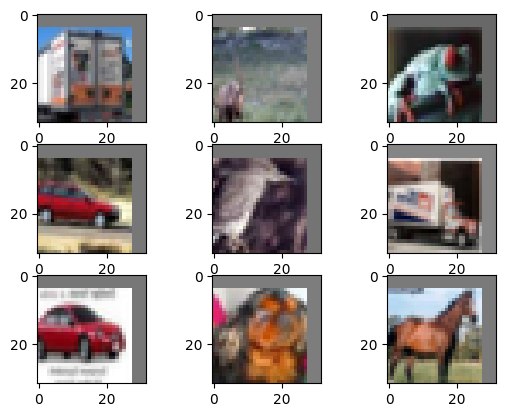

In [18]:
transforms_list = [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()]
bx_transformed = bx
for t in transforms_list:
  bx_transformed = t(bx_transformed)
show_batch(bx_transformed)

In [19]:
class dataset(Dataset):
  def __init__(self, x, y, train=True):
    self.x = x
    self.y = y
    self.train = train
    self.transforms_list = [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()]

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x_example, y_example = self.x[index], self.y[index]
    if self.train:
      for t in self.transforms_list:
        x_example = t(x_example)

    return x_example, y_example

In [20]:
bs=128

trainset = dataset(x_train, y_train, train=True)
testset = dataset(x_test, y_test, train=False)
train_loader = DataLoader(trainset, batch_size=bs, shuffle=True)
valid_loader = DataLoader(testset, batch_size=bs)

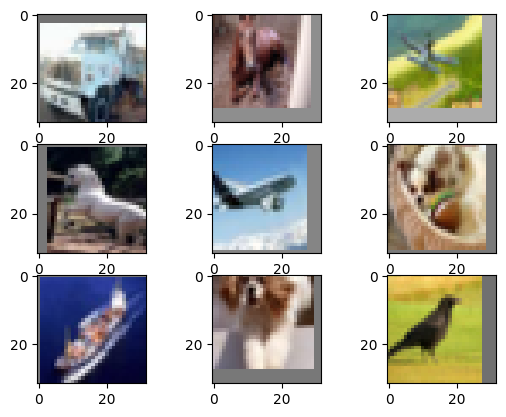

In [21]:
bx, by = next(iter(train_loader))
show_batch(bx)

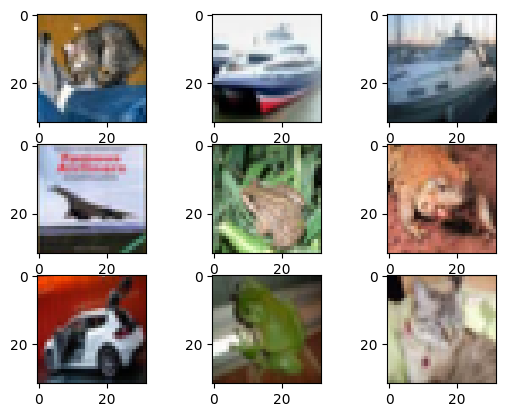

In [22]:
bx, by = next(iter(valid_loader))
show_batch(bx)

In [23]:
class ConvNet(nn.Module):
  def __init__(self, layer_filters, stride, kernel_size=3, h=32, w=32, num_classes=10):
    super(ConvNet, self).__init__()
    self.layer_filters = layer_filters
    self.num_layers = len(layer_filters) - 1
    self.layers = nn.ModuleDict()
    for layer in range(1, self.num_layers+1):
      self.layers.add_module(f'layer_{layer}', nn.Conv2d(layer_filters[layer-1], layer_filters[layer], kernel_size, stride, kernel_size//2))
      self.layers.add_module(f'layer_{layer}_bn', nn.BatchNorm2d(layer_filters[layer]))

    self.global_pooling = nn.AdaptiveAvgPool2d(1) # [bs, layer_filters[self.num_layers]]
    self.classification = nn.Linear(layer_filters[self.num_layers], num_classes)

  def forward(self, x):
    for layer_name in self.layers.keys():
      x = self.layers[layer_name](x)
      if 'bn' not in layer_name:
        x = nn.ReLU()(x)

    x = self.global_pooling(x)
    x = x.view(-1, self.layer_filters[-1])
    x = self.classification(x)
    return x

In [24]:
stride = 2
kernel_size = 3
lr = 0.001

model = ConvNet(layer_filters, stride, kernel_size)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train_eval(model, optimizer, train_loader, valid_loader, epoch=10)

epoch 0; loss 2.1322; accuracy 0.24
epoch 1; loss 1.9600; accuracy 0.30
epoch 2; loss 1.9370; accuracy 0.34
epoch 3; loss 1.8772; accuracy 0.36
epoch 4; loss 1.6008; accuracy 0.38
epoch 5; loss 1.6572; accuracy 0.39
epoch 6; loss 1.7686; accuracy 0.40
epoch 7; loss 1.5912; accuracy 0.41
epoch 8; loss 1.6423; accuracy 0.42
epoch 9; loss 1.6438; accuracy 0.43


Use Active-LR

In [25]:
!wget https://raw.githubusercontent.com/davoodwadi/active-lr/main/optimizers/ActiveSGD.py
from ActiveSGD import ActiveSGD
stride = 2
kernel_size = 3
lr = 0.01
momentum = 0.9
weight_decay=5e-4
epoch = 100

model = ConvNet(layer_filters, stride, kernel_size)
optimizer = ActiveSGD(model.parameters(), stepSize=len(train_loader), lr=lr, momentum=momentum, weight_decay=weight_decay)
train_eval(model, optimizer, train_loader, valid_loader, epoch=epoch)

--2023-09-29 12:33:48--  https://raw.githubusercontent.com/davoodwadi/active-lr/main/optimizers/ActiveSGD.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4148 (4.1K) [text/plain]
Saving to: ‘ActiveSGD.py’

ActiveSGD.py        100%[===================>]   4.05K  --.-KB/s    in 0s      

2023-09-29 12:33:48 (62.5 MB/s) - ‘ActiveSGD.py’ saved [4148/4148]

epoch 0; loss 1.7470; accuracy 0.49
epoch 1; loss 1.3506; accuracy 0.55
epoch 2; loss 1.1392; accuracy 0.61
epoch 3; loss 1.3001; accuracy 0.62
epoch 4; loss 1.2737; accuracy 0.63
epoch 5; loss 1.1635; accuracy 0.65
epoch 6; loss 0.9262; accuracy 0.66
epoch 7; loss 0.9601; accuracy 0.67
epoch 8; loss 0.9228; accuracy 0.66
epoch 9; loss 1.0743; accuracy 0.68
epoch 10; loss 0.9889; accuracy 0.68
epoch 11; los

Learning rate decay

In [26]:
optimizer.param_groups[0]['lr'] /= 10
optimizer.param_groups[0]['lr']

0.001

In [27]:
epoch = 50
train_eval(model, optimizer, train_loader, valid_loader, epoch=epoch)

epoch 0; loss 0.5068; accuracy 0.78
epoch 1; loss 0.4617; accuracy 0.78
epoch 2; loss 0.6926; accuracy 0.78
epoch 3; loss 0.8363; accuracy 0.78
epoch 4; loss 0.5356; accuracy 0.78
epoch 5; loss 0.4586; accuracy 0.78
epoch 6; loss 0.7881; accuracy 0.78
epoch 7; loss 0.6490; accuracy 0.78
epoch 8; loss 0.6555; accuracy 0.78
epoch 9; loss 0.6972; accuracy 0.78
epoch 10; loss 0.8522; accuracy 0.78
epoch 11; loss 0.5083; accuracy 0.79
epoch 12; loss 0.6346; accuracy 0.78
epoch 13; loss 0.5397; accuracy 0.78
epoch 14; loss 0.6818; accuracy 0.78
epoch 15; loss 0.5329; accuracy 0.78
epoch 16; loss 0.5369; accuracy 0.78
epoch 17; loss 0.7502; accuracy 0.79
epoch 18; loss 0.4465; accuracy 0.78
epoch 19; loss 0.5499; accuracy 0.78
epoch 20; loss 0.5856; accuracy 0.79
epoch 21; loss 0.6344; accuracy 0.79
epoch 22; loss 0.6111; accuracy 0.78
epoch 23; loss 0.8601; accuracy 0.79
epoch 24; loss 0.4959; accuracy 0.78
epoch 25; loss 0.7979; accuracy 0.79
epoch 26; loss 0.6983; accuracy 0.79
epoch 27; l

## ResNet

In [30]:
resnet18??

In [31]:
model = resnet18(weights=None, num_classes=10)
model.fc

Linear(in_features=512, out_features=10, bias=True)

In [32]:
lr = 0.01
momentum = 0.9
weight_decay=5e-4
epoch = 10

optimizer = ActiveSGD(model.parameters(), stepSize=len(train_loader), lr=lr, momentum=momentum, weight_decay=weight_decay)
train_eval(model, optimizer, train_loader, valid_loader, epoch=epoch)

epoch 0; loss 1.5350; accuracy 0.52
epoch 1; loss 1.5471; accuracy 0.58
epoch 2; loss 0.9124; accuracy 0.63
epoch 3; loss 0.9265; accuracy 0.67
epoch 4; loss 1.0520; accuracy 0.68
epoch 5; loss 0.8145; accuracy 0.70
epoch 6; loss 0.9578; accuracy 0.70
epoch 7; loss 0.9975; accuracy 0.74
epoch 8; loss 0.6255; accuracy 0.72
epoch 9; loss 0.7806; accuracy 0.75


Transfer learning with ImageNet weights

In [33]:
from torchvision.models import ResNet18_Weights

In [36]:
model = resnet18(weights=ResNet18_Weights, num_classes=1000)
model.fc

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 261MB/s]


Linear(in_features=512, out_features=1000, bias=True)

In [37]:
model.fc = nn.Linear(512, 10)
model.fc

Linear(in_features=512, out_features=10, bias=True)

In [38]:
lr = 0.01
momentum = 0.9
weight_decay=5e-4
epoch = 10

optimizer = ActiveSGD(model.parameters(), stepSize=len(train_loader), lr=lr, momentum=momentum, weight_decay=weight_decay)
train_eval(model, optimizer, train_loader, valid_loader, epoch=epoch)

epoch 0; loss 0.8193; accuracy 0.75
epoch 1; loss 0.5374; accuracy 0.79
epoch 2; loss 0.6814; accuracy 0.81
epoch 3; loss 0.5101; accuracy 0.81
epoch 4; loss 0.6787; accuracy 0.82
epoch 5; loss 0.4882; accuracy 0.84
epoch 6; loss 0.4267; accuracy 0.84
epoch 7; loss 0.4453; accuracy 0.84
epoch 8; loss 0.2785; accuracy 0.83
epoch 9; loss 0.2980; accuracy 0.84


ResNet18 has been pre-trained on ImageNet. To get optimal performance

1. Use the pre-train image size `(224, 224)`
2. Normalize your data using the ImageNet mean and sd `torchvision.transforms.normalize`
3. Use gradual unfreezing
4. Use differential learning rates

# Bonus
## fast.ai library for transfer learning

In [39]:
from fastai.vision.all import *

In [45]:
cifar_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train

In [193]:
def get_xy(ds):
  return range(len(ds.data))
def get_image(index):
  return cifar_train.data[index]
def get_label(index):
  return cifar_train.classes[cifar_train.targets[index]]

In [194]:
datablock = DataBlock(blocks=(ImageBlock, CategoryBlock(vocab=vocab)),
                  get_items=get_xy,
                  splitter=RandomSplitter(seed=1),
                  get_x=get_image,
                  get_y=get_label,
                  batch_tfms=aug_transforms(size=224),
                  )

In [195]:
dls = datablock.dataloaders(cifar_train, bs=128)
dls

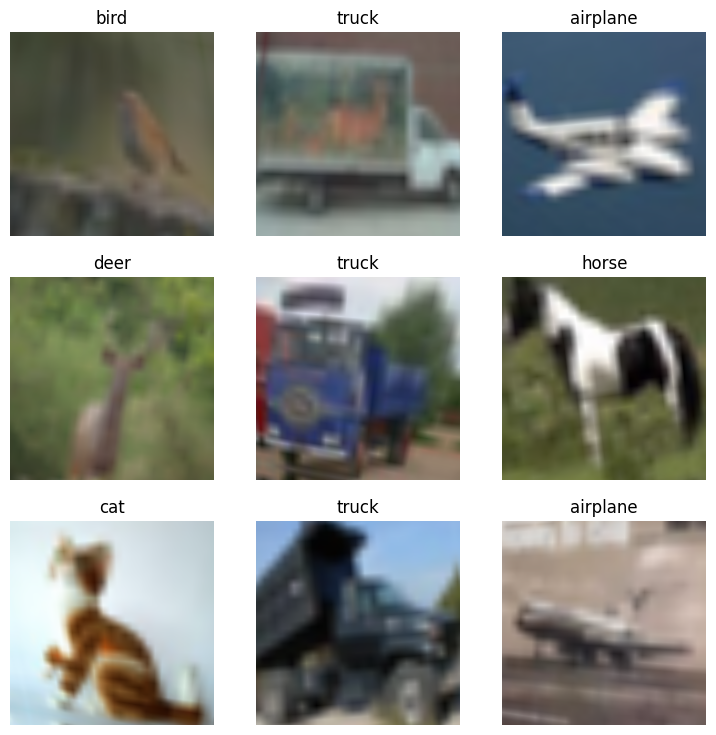

In [196]:
dls.show_batch()

In [197]:
bx, by = dls.one_batch()
bx.shape, by.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [198]:
learn = vision_learner(dls, resnet18, metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0008317637839354575)

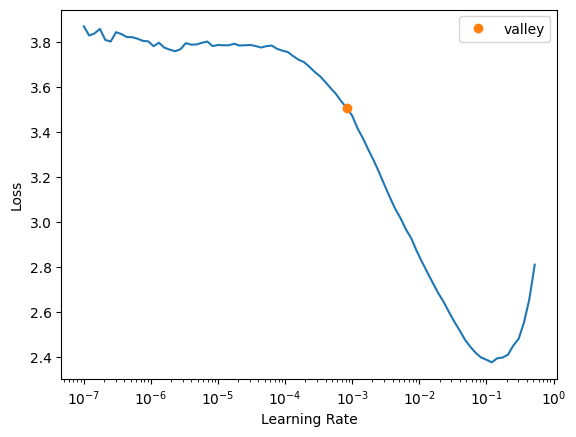

In [152]:
learn.lr_find()

In [199]:
learn.fine_tune(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.021372,0.568158,0.806000,01:53


epoch,train_loss,valid_loss,accuracy,time
0,0.530956,0.315405,0.891400,02:21
1,0.345665,0.227213,0.923400,02:21
2,0.246767,0.195645,0.932000,02:21
3,0.217917,0.190468,0.933800,02:21
